In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torchvision.models as models
import numpy as np

In [2]:
train_set = CIFAR10(root='/', download=True, train=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 88127718.17it/s] 


Extracting /cifar-10-python.tar.gz to /


In [3]:
# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_set[i][0]) for i in range(len(train_set))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

In [4]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [5]:
train_set = CIFAR10(root='/', download=True, train=True, transform=transform_train)
train_set, val_set = torch.utils.data.random_split(train_set, [0.8, 0.2])
test_set = CIFAR10(root='/', download=True, train=False, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [7]:
# ResNet9
def conv_block(in_channels, out_channels, relu=True, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    ]
    if relu: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.fc = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.fc(x)
        return x


In [17]:
def conv_block(in_channels, out_channels, relu=True, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
    ]
    if relu: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)

        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128, relu=False))

        self.res2 = nn.Sequential(conv_block(128, 256), conv_block(256, 512, relu=False))
        self.upsample = nn.Conv2d(128, 512, kernel_size=1)

        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512, relu=False))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        x = self.maxpool(self.relu(self.res1(x) + x))
        # print(x.shape)
        x = self.maxpool(self.relu(self.res2(x) + self.upsample(x)))
        # print(x.shape)
        x = self.maxpool(self.relu(self.res3(x) + x))
        # print(x.shape)
        x = self.fc(x)
        return x

In [18]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet9().to(device)

lr=1e-3
weight_decay=1e-2
criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [19]:
def train(epochs):
    val_losses = []
    train_losses = []

    for epoch_num in range(epochs):
        model.train()

        epoch_losses = 0

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x)

            loss = criterion(batch_y_preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses += (len(batch_y)*loss.item())

        epoch_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        correctly_labelled = 0
        with torch.no_grad():
            val_epoch_losses = 0
            for val_batch_x, val_batch_y in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x)
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

                correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item()

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss)
        scheduler.step()
        print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={scheduler.get_last_lr()} train_loss={epoch_loss:.2f}, val_loss={val_epoch_loss:.2f}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100:.2f}% accuracy)')
    print('Training Done')
    return train_losses, val_losses


In [25]:
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(5)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/5, learning_rate=[0.0005688000922764595] train_loss=0.62, val_loss=0.61. labelled 7951/10000 correctly (79.51% accuracy)
Epoch: 2/5, learning_rate=[0.0005403600876626365] train_loss=0.60, val_loss=0.65. labelled 7771/10000 correctly (77.71% accuracy)
Epoch: 3/5, learning_rate=[0.0005133420832795047] train_loss=0.58, val_loss=0.62. labelled 7867/10000 correctly (78.67% accuracy)
Epoch: 4/5, learning_rate=[0.00048767497911552944] train_loss=0.58, val_loss=0.63. labelled 7835/10000 correctly (78.35% accuracy)
Epoch: 5/5, learning_rate=[0.00046329123015975297] train_loss=0.55, val_loss=0.57. labelled 8095/10000 correctly (80.95% accuracy)
Training Done


In [26]:
cycle_train_losses, cycle_val_losses = train(5)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/5, learning_rate=[0.0004401266686517653] train_loss=0.54, val_loss=0.58. labelled 8077/10000 correctly (80.77% accuracy)
Epoch: 2/5, learning_rate=[0.00041812033521917703] train_loss=0.53, val_loss=0.57. labelled 8085/10000 correctly (80.85% accuracy)
Epoch: 3/5, learning_rate=[0.00039721431845821814] train_loss=0.52, val_loss=0.51. labelled 8243/10000 correctly (82.43% accuracy)
Epoch: 4/5, learning_rate=[0.0003773536025353072] train_loss=0.50, val_loss=0.56. labelled 8048/10000 correctly (80.48% accuracy)
Epoch: 5/5, learning_rate=[0.0003584859224085418] train_loss=0.49, val_loss=0.53. labelled 8197/10000 correctly (81.97% accuracy)
Training Done


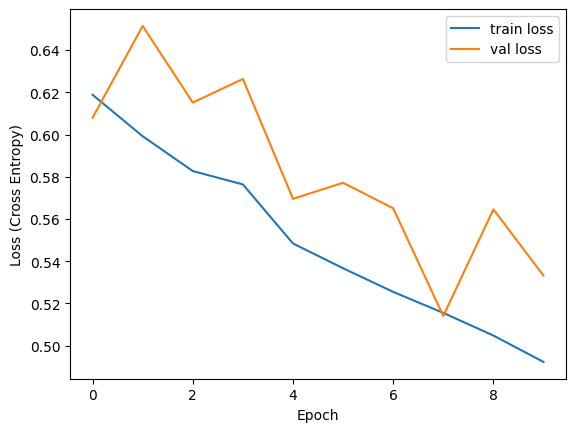

In [27]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

In [28]:
model.eval()
correctly_labelled = 0
with torch.no_grad():
    val_epoch_losses = 0
    for test_batch_x, test_batch_y in test_loader:
        test_batch_x = test_batch_x.to(device)
        test_batch_y = test_batch_y.to(device)

        test_batch_y_preds = model(test_batch_x)
        test_loss = criterion(test_batch_y_preds, test_batch_y)

        correctly_labelled += (test_batch_y_preds.argmax(dim=1) == test_batch_y).sum().item()

    test_epoch_loss = val_epoch_losses/len(test_loader.dataset)
    print(f'Labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


Labelled 8283/10000 correctly (82.83% accuracy)


In [24]:
print(model)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): Sequen